# Accessing Power BI Datasets via XMLA Endpoint in Python Jupyter Notebook
> In this blog post I show how you can use Python to access datasets published to Power BI service using Python in Jupyter Notebook  

- toc: true 
- badges: true
- comments: true
- categories: [PPU, XMLA, PowerBI_Premium, Premium, Python, Jupyter_Notebook]
- hide: false

Power BI recently announced availability of a new license ['Premium Per User'](https://powerbi.microsoft.com/en-us/blog/power-bi-premium-per-user-public-preview-now-available/) which will allow small to medium size companies to access Premium features at a lower price point (as of 12/11/2020 price has not been published) . I was given a priority access to it and have been exploring all the premium features for the last few weeks. One of the key benefits of Premium is the ability to consume published datasets via XMLA endpoint. Instead of me describing it, you can read Microsoft's documentation for detailed description [here](https://docs.microsoft.com/en-us/power-bi/admin/service-premium-connect-tools).   

To use XMLA endpoint, you will need to have a Premium workspace and enable the 'XMLA Endpoint' in capacity settings. 

Capacity Settings > Power BI Premium > Workloads > XMLA Endpoint

![image](https://docs.microsoft.com/en-us/power-bi/admin/media/service-premium-connect-tools/xmla-endpoint-enable.png)

In this blog post I will show how to setup connection to the XMLA endpoint and access Power BI datasets & measures within those datasets using Python in a Jupyter notebook. This blog post is written in a Jupyter notebook. I use Jupyter notebooks for data exploration, visualization and building machine learning models. Ability to consume published datasets in a notebook will be immensly helpful to me.   

I took inspiration from [David Elderveld's](https://www.linkedin.com/in/davideldersveld/) amazing [4-part blogposts](https://dataveld.com/2020/08/17/jupyter-as-an-external-tool-for-power-bi-desktop-python-part-4/) on *'Jupyter as an External Tool for Power BI Desktop'*. It really opened up lot of options that I didn't know existed, thanks David! I highly encourage you to read all the four posts to learn more about using Python with Power BI. 

Secondly, none of this would be possible without the `python-ssas` [module](https://github.com/yehoshuadimarsky/python-ssas/) by Josh Dimarsky which enables TOM connection to Analysis Services. 

To get started, you will need three things:
- install the [pythonnet](https://github.com/pythonnet/pythonnet) library (`pip install pythonnet`)
- Make sure you have `Microsoft.AnalysisServices.Tabular.dll` and `Microsoft.AnalysisServices.AdomdClient.dll` dlls. If you use Excel, Power BI, you will most likley already have them. As Josh mentions in his documentation, they are usually installed in `C:\Windows\Microsoft.NET\assembly\GAC_MSIL`
- copy the `ssas_api.py` file from [here](https://github.com/yehoshuadimarsky/python-ssas/blob/master/ssas_api.py) and save it in your Python libraries folder or Jupyter working directory.

In [245]:
import pandas as pd
import ssas_api as ssas
import seaborn as sns

## Connect to Premium Workspace

First we want to connect to our Power BI service account & the Premium workspace. You will need to find the workspace connection string URL. It will be in this format `powerbi://api.powerbi.com/v1.0/[tenant name]/[workspace name]`. You can obtain it from your workspace settings (see below)

First go to your Premium Workspace and click on Settings. Notice that I have three datasets in this workspace, viz Dataset1, dataset2 and dataset2_2.
    
![ws_settings](https://raw.githubusercontent.com/pawarbi/blog/master/images/xmla1.jpg)    

Next, copy the server address from Workspace Connection:

![connection](https://raw.githubusercontent.com/pawarbi/blog/master/images/xmla2.jpg)

Create variables for your tenant username and password 

In [213]:
server = 'workspace_connection_from_above'

username = 'name@email.com'

password = 'password'

Setup connection string by specifying the server name, username & password. Note that I have left the database name (`db_name`) blank here because I am assuming that we don't know the names of the datasets that are available in this workspace. We will explore the workspace and get a list of all the datasets. If you already know the dataset name, you can enter it between the single quotations. 

In [216]:
conn1 = ssas.set_conn_string(
    server=server,
    db_name='',
    username=username,
    password=password
    )

Import libraries for [Tabular Object Model](https://docs.microsoft.com/en-us/analysis-services/tom/introduction-to-the-tabular-object-model-tom-in-analysis-services-amo?view=asallproducts-allversions) (TOM) and setup the TOM server. As long as your username and password are valid, you will connect to your workspace using TOM. If it fails, it means either your credentials are incorrect or you do not have access to the workspace. You will *not* be prompted for interactive authentication. 

In [217]:
global System, DataTable, AMO, ADOMD

import System
from System.Data import DataTable
import Microsoft.AnalysisServices.Tabular as TOM
import Microsoft.AnalysisServices.AdomdClient as ADOMD

try:
    TOMServer = TOM.Server()
    TOMServer.Connect(conn1)
    print("Connection to Workspace Successful !")
    
except:
    print("Connection to Workspace Failed")
    


Connection to Workspace Successful !


## Access Datasets

Let's now get a list of all the avaible datasets in this workspace and their metadata such as compatibility level, database id, size in megabytes, creation date and last update date. 

In [218]:
datasets = pd.DataFrame(columns=['Dataset_Name', 'Compatibility', 'ID', 'Size_MB','Created_Date','Last_Update' ])

for item in TOMServer.Databases:
    
          
    datasets = datasets.append({'Dataset_Name' :item.Name, 
                     'Compatibility':item.CompatibilityLevel,
                     'Created_Date' :item.CreatedTimestamp,
                     'ID'           :item.ID,
                     'Last_Update'  :item.LastUpdate,
                     'Size_MB'      :(item.EstimatedSize*1e-06)    },
                     ignore_index=True)
    
datasets    

,Dataset_Name,Compatibility,ID,Size_MB,Created_Date,Last_Update
0,Dataset1,1465,a28e52a8-d6b3-4b5c-8e61-e107fbd52748,1.916094,8/21/2018 3:34:53 PM,12/11/2020 11:24:21 AM
1,dataset2_2,1520,a93244fe-860d-45c2-9d36-b44fb284c54d,0.454222,12/11/2020 10:01:57 AM,12/11/2020 11:20:50 AM


I have three datasets in this workspace but I only see 2! The reason is that dataset2 was created by uploading the csv file to the worspace while the other two datasets were published to the workspace from Power BI Desktop. Also note that their compatibility levels are different. Dataset1 was published with the old version of Power BI Desktop with 'Enhanced Metadata' option turned off that's why its compatibility level is not 1520.  Since [September 2020 release](https://docs.microsoft.com/en-us/power-bi/connect-data/desktop-enhanced-dataset-metadata), Power BI Desktop automatically converts the datasets to Enhanced Metadata. 

Now let's choose the dataset we want to connect to. In this case I want to access `dataset2_2`. I will copy the database id from the `ID` column from the above table. Then we will find the names of all the tables that are available in that dataset. 

In [219]:
ds = TOMServer.Databases['a93244fe-860d-45c2-9d36-b44fb284c54d']

for table in ds.Model.Tables:
    print(table.Name)

dataset2


In the `dataset2_2` dataset, the only available table is `dataset2`. Let's connect to this table. We will create a new connection string by specifying the `db_name` this time. 

In [223]:
conn2 = (ssas.set_conn_string(
    server=server,
    db_name='dataset2_2',
    username = 'name@email.com',
    password = 'password'
 ))

You can write any valid DAX query against this table and get the results back as a Pandas dataframe.

In [226]:
dax_string = '''
    //Write your DAX Query here
    EVALUATE
    dataset2
    '''

df_dataset2 = (ssas
               .get_DAX(
                   connection_string=conn, 
                   dax_string=dax_string)
               
              )

df_dataset2.head()

,dataset2[vendorID],dataset2[passengerCount],dataset2[tripDistance],dataset2[hour_of_day],dataset2[day_of_week],dataset2[day_of_month],dataset2[month_num],dataset2[normalizeHolidayName],dataset2[isPaidTimeOff],dataset2[snowDepth],dataset2[precipTime],dataset2[precipDepth],dataset2[temperature],dataset2[totalAmount]
0,2,1,2.62,2,6,19,6,None,False,0.0,1,0,23.116071,11.80
1,2,1,0.42,17,6,19,6,None,False,0.0,1,0,23.116071,4.30
2,2,1,1.78,18,6,19,6,None,False,0.0,1,0,23.116071,12.96
3,2,1,1.26,16,6,19,6,None,False,0.0,1,0,23.116071,9.36
4,2,1,2.37,22,6,19,6,None,False,0.0,1,0,23.116071,10.80


<AxesSubplot:xlabel='dataset2[totalAmount]'>

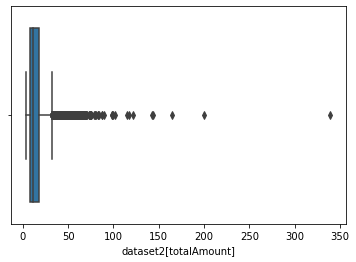

In [244]:
sns.boxplot(df_dataset2['dataset2[totalAmount]'])

## Access Measures

We can also get a list of all the measures and their DAX expressions. As seen below, in this table we have only one measure called `totalAmount average per vendorID` with its DAX.

In [232]:
table = ds.Model.Tables.Find('dataset2')

for measure in table.Measures:
    print(measure.Name, ":\n", measure.Expression)

totalAmount average per vendorID :
 
AVERAGEX(
	KEEPFILTERS(VALUES('dataset2'[vendorID])),
	CALCULATE(SUM('dataset2'[totalAmount]))
)


Based on [this](https://docs.microsoft.com/en-us/power-bi/admin/service-premium-connect-tools) Microsoft documentation, I was under the impression that only the datasets with Compatibility level 1500 or higher could be accessed via XMLA. That's not the case. `Dataset1` has a compatibility of 1465 and can still be access via XMLA endpoint as seen below. 

In [233]:
conn3 = (ssas.set_conn_string(
    server=server,
    db_name='Dataset1',
    username = 'name@email.com',
    password = 'password'
 ))

dax_string2 = '''
    //Write your DAX Query here
    EVALUATE
    KeyInfluencers_Predictors
    '''

df_dataset1 = (ssas
               .get_DAX(
                   connection_string=conn3, 
                   dax_string=dax_string2)
               
              )

df_dataset1.head()

,KeyInfluencers_Predictors[Feature Name],KeyInfluencers_Predictors[Feature Type],KeyInfluencers_Predictors[Feature Importance]
0,col6,Numeric,0.417869
1,col0,Numeric,0.257106
2,col4,Numeric,0.106939
3,col3,Numeric,0.090845
4,col1,Numeric,0.066334


Datasets in Power BI service can currently be accessed via number of different tools (SSDT, SSMS, PowerShell, Tabular Editor, DAX Studio, ALM Toolkit) which are all database modeling tools. But Data Scientists now can easily access the datasets for exploring the data and building machine learning models in Jupyter Notebook or VSCode using Python.  

This method can also be used to export multiple refreshed dataset(s) on a schedule and on demand. 

There are still few things I am not sure about and need to explore more. 
- Can I use service principal, key etc so I don't have to write username/password in my code
- How to write back, create dataset using Python and push it to the workspace
- Can I create/modify measures?
- What are the limitations ? 


Please feel free to post your comments below or reach out to me if you find any errors or have suggestions.

## References:

- https://dataveld.com/2020/07/20/python-as-an-external-tool-for-power-bi-desktop-part-1/
- https://powerbi.microsoft.com/en-us/blog/power-bi-premium-per-user-public-preview-now-available/
- https://github.com/yehoshuadimarsky/python-ssas/
- https://docs.microsoft.com/en-us/power-bi/admin/service-premium-connect-tools
- https://docs.microsoft.com/en-us/analysis-services/tom/introduction-to-the-tabular-object-model-tom-in-analysis-services-amo?view=asallproducts-allversions
- https://docs.microsoft.com/en-us/dotnet/api/microsoft.analysisservices.tabular.measure?view=analysisservices-dotnet

    
    